# Predict Career Longevity for NBA Rookies

## Imports

In [1]:
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import pickle
import requests
import json

import constants as c

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

## Loading data

In [2]:
raw_train_set: pd.DataFrame = pd.read_csv(c.TRAIN_DATA)
X_test: pd.DataFrame = pd.read_csv(c.TEST_DATA)
labels_test: pd.DataFrame = pd.read_csv(c.LABELS_TEST)

## Analysis of raw data

The raw dataset is composed of 19 variables representing statistics of performances for each player. The players are binary classified between those having a long career in NBA or not.

All attributes are numeric : percentages, time, binary data, integers. We do not need here to create bins from descriptive data. The module _describe_ from library _pandas_ under Python shows characteristics of the distribution of data, for each attributes.

In [3]:
raw_train_set.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
count,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000
mean,59.008156,16.928284,6.502344,2.511125,5.645747,43.912555,0.241959,0.767455,19.050425,1.241914,1.741848,70.495847,0.958240,1.937014,2.891927,1.472706,0.589403,0.344204,1.150499,0.499546
std,17.236886,8.034209,4.163856,1.611502,3.422292,6.106910,0.363008,1.017214,15.513640,0.937585,1.272047,10.381068,0.771344,1.342627,2.039694,1.376592,0.386147,0.418840,0.687706,0.500227
min,11.000000,3.100000,1.100000,0.400000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,46.223257,10.492268,3.587756,1.400000,3.200000,40.000000,0.000000,0.000000,0.000000,0.600000,0.900000,64.900000,0.400000,1.000000,1.400000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,59.387147,15.386486,5.200000,2.000000,4.600000,43.652785,0.100000,0.300000,22.600000,1.000000,1.400000,71.502462,0.700000,1.600000,2.273596,1.041951,0.500000,0.200000,0.988945,0.000000
75%,76.000000,21.830403,8.300000,3.200000,6.900000,47.700000,0.400000,1.195634,32.300000,1.600000,2.200000,77.436718,1.300000,2.500000,3.700000,1.900000,0.800000,0.400000,1.400000,1.000000
max,82.000000,40.900000,24.300000,9.000000,18.900000,73.700000,2.300000,6.500000,100.000000,7.500000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.200000,1.000000


The analysis gives us some information :
* There is no missing values in the DataFrame. For the sake of generality of this notebook, we need to analyse also the case where we have missing values. If some attributes have too many missing values, then we must prefer to remove those columns from the DataFrame, as the column does not carry information worthy enough for the learning. In the case there are only some missing values, therefore we can complete those with _KNN Imputing_, which consists in completing missing values by the mean (or median or frequence, for descriptive data) of the values of the nearest neighbors.
* From the target column, the dataset is really well balanced as approximately half of the dataset is targetted at 1 and the other half at 0. In case of imbalancement in the dataset, it is necessary to deal with it as it may introduce bias in learning. Two solutions are possible as well : either we randomly choose rows from the dataset to constitute a new one with better balancement between the two classes, or we choose to generate synthetic samples in the dataset to enhance the size of the little class. This can be performed using SMOT algorithm, for example.

The following section propose some general data cleaning, even if it not necessary here.

## Data cleaning

We may check if there are duplicates in the dataset.

In [4]:
cols_to_drop: List = [c.TARGET]
raw_attributes: pd.DataFrame = raw_train_set.drop(columns=cols_to_drop)
mask_duplicates: pd.Series = raw_attributes.duplicated(keep=False)
raw_train_set[mask_duplicates].shape[0]

34

We find 34 lines having at least one duplicate in the attributes.

In [5]:
raw_train_set[mask_duplicates]

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
23,33.0,7.8,3.8,1.5,3.1,48.0,0.0,0.3,10.0,0.8,1.0,82.4,0.5,0.6,1.1,0.4,0.4,0.1,0.4,1
28,77.0,30.0,13.6,6.1,13.9,43.9,0.2,0.9,24.6,1.2,1.6,73.4,1.3,3.3,4.6,1.8,0.9,0.3,1.5,0
58,71.0,30.4,16.3,6.1,12.4,49.5,0.0,0.0,0.0,4.0,5.5,72.5,2.4,4.1,6.5,1.5,1.0,1.3,2.1,1
73,44.0,7.6,2.5,1.0,2.1,46.2,0.0,0.2,11.1,0.5,0.9,56.1,0.5,0.8,1.3,0.4,0.3,0.0,0.4,0
85,71.0,30.4,16.3,6.1,12.4,49.5,0.0,0.0,0.0,4.0,5.5,72.5,2.4,4.1,6.5,1.5,1.0,1.3,2.1,0
129,60.0,8.7,2.9,1.0,2.2,44.4,0.0,0.1,0.0,0.9,1.3,69.7,0.2,0.9,1.2,1.7,0.6,0.1,0.6,1
136,80.0,37.0,21.9,8.0,17.6,45.1,1.1,3.4,32.1,5.0,6.2,79.6,2.1,4.3,6.4,2.5,1.4,0.3,3.9,1
214,80.0,37.0,21.9,8.0,17.6,45.1,1.1,3.4,32.1,5.0,6.2,79.6,2.1,4.3,6.4,2.5,1.4,0.3,3.9,0
224,78.0,20.1,8.4,3.0,5.8,52.0,0.0,0.1,0.0,2.3,3.6,64.8,1.8,3.3,5.1,1.6,0.6,0.8,1.8,0
334,82.0,23.7,8.7,3.5,7.5,46.4,0.1,0.4,20.6,1.7,1.9,87.3,0.5,1.7,2.2,4.2,1.0,0.2,1.7,1


We show that in the duplicates identified, there are some duplicates which does not have the same target. This is incoherent, and it should be removed for the learning. We remove all lines for which the target is different, and we remove exact duplicates to keep only one example.

In [6]:
# We focus on lines which are duplicates for attributes only but does not have the same target.
mask_duplicates_label: pd.Series = mask_duplicates & ~raw_train_set.duplicated(keep=False)

# We remove those lines
data_no_incoherences: pd.DataFrame = raw_train_set[~mask_duplicates_label]

In [7]:
# Now, let's eliminate the remaining duplicates
data_no_duplicates: pd.DataFrame = data_no_incoherences.drop_duplicates()

In [8]:
data_no_duplicates.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
count,1074.000000,1074.000000,1074.000000,1074.000000,1074.00000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000
mean,58.890112,16.879740,6.464042,2.495949,5.61496,43.895924,0.242549,0.766544,19.153741,1.233377,1.732193,70.451236,0.959518,1.935617,2.891445,1.467458,0.587088,0.344850,1.144785,0.499069
std,17.167162,7.975991,4.111401,1.591301,3.37927,6.127534,0.363575,1.017687,15.567303,0.923626,1.256914,10.364759,0.772982,1.343053,2.041214,1.383992,0.386256,0.420347,0.679618,0.500232
min,11.000000,3.100000,1.100000,0.400000,1.00000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,46.407281,10.568007,3.524742,1.400000,3.20000,39.925000,0.000000,0.000000,0.000000,0.600000,0.892513,64.900000,0.400000,1.000000,1.413289,0.600000,0.300000,0.100000,0.700000,0.000000
50%,59.000000,15.245734,5.200000,2.000000,4.60000,43.500000,0.100000,0.300000,22.954800,1.000000,1.400000,71.429861,0.700000,1.600000,2.293165,1.000000,0.500000,0.200000,0.963657,0.000000
75%,75.453975,21.775000,8.100000,3.100000,6.90000,47.600000,0.400000,1.186558,32.500000,1.600000,2.200000,77.396834,1.300000,2.500000,3.700000,1.900000,0.800000,0.400000,1.400000,1.000000
max,82.000000,40.900000,24.300000,9.000000,18.90000,73.700000,2.300000,6.500000,100.000000,7.500000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.200000,1.000000


Now, we focus on outliers in the dataset. We use the metric of Z-Score to remove those. The Z-score corresponds to an integer number of standard deviations from the mean. We consider as outliers values which are outside the range $[ \mu - 5\sigma, \mu + 5\sigma ]$. We exclude from this study numerical attributes in percentage.

In [9]:
cols_to_drop_perc: List[str] = cols_to_drop + [c.FT_PERC, c.THREEP_PERC, c.FG_PERC]
attributes_no_duplicates: pd.DataFrame = data_no_duplicates.drop(columns=cols_to_drop_perc)
mask_outliers: pd.Series = (np.abs(stats.zscore(attributes_no_duplicates)) < 5).all(axis=1)
data_no_outliers: pd.DataFrame = data_no_duplicates[mask_outliers]

In [10]:
data_no_outliers.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,58.658793,16.653667,6.332781,2.448774,5.520139,43.856383,0.236849,0.751996,19.147425,1.202212,1.689797,70.409263,0.944790,1.896373,2.837428,1.427474,0.578824,0.333241,1.122431,0.493874
std,17.116935,7.734329,3.910231,1.526676,3.264792,6.127569,0.347390,0.977670,15.556006,0.856585,1.160808,10.374133,0.745044,1.274232,1.946510,1.296350,0.373772,0.372382,0.649403,0.500198
min,11.000000,3.100000,1.100000,0.400000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,46.000000,10.492268,3.500000,1.398292,3.200000,39.900000,0.000000,0.000000,0.000000,0.600000,0.878322,64.900000,0.400000,1.000000,1.400000,0.573839,0.300000,0.100000,0.700000,0.000000
50%,59.000000,15.100000,5.200000,2.000000,4.500000,43.500000,0.100000,0.300000,22.915127,1.000000,1.392219,71.400000,0.700000,1.511909,2.245744,1.000000,0.500000,0.200000,0.948930,0.000000
75%,75.000000,21.400000,8.000000,3.100000,6.800000,47.600000,0.390213,1.128974,32.500000,1.588420,2.200000,77.300000,1.300000,2.400000,3.600000,1.900000,0.765132,0.400000,1.400000,1.000000
max,82.000000,39.700000,21.400000,8.900000,18.900000,73.700000,1.900000,5.100000,100.000000,5.400000,7.300000,100.000000,4.300000,7.700000,11.100000,8.300000,2.500000,2.400000,4.200000,1.000000


We apply imputing transformation for missing data with _KNNImputing_

In [11]:
# Preparing dataset for learning
labels_train: pd.Series = data_no_outliers[c.TARGET]
attributes_no_outliers: pd.DataFrame = data_no_outliers.drop(columns=cols_to_drop)
attributes_no_outliers_values: np.array = attributes_no_outliers.values

# KNN Imputing
imputer: KNNImputer = KNNImputer()
imputer.fit(attributes_no_outliers_values)
attributes_imputed: np.array = imputer.transform(attributes_no_outliers_values)

# Converting back to Pandas DataFrame
attributes: pd.DataFrame = pd.DataFrame(attributes_imputed, index=attributes_no_outliers.index, columns=attributes_no_outliers.columns)

## Feature Engineering

We want to study the potential relationship between the variables and the construction of new features which will be meaningful for learning. We can infer some hypothesis on the level of the player regarding the statistics we have. Let's consider a player being better than an other will have a longer career in NBA. This can corresponds to higher numerican quantities for the better player (in number of 3 points made, in number of tentatives to hit 3 points, etc.) except for the turnover attribute. Then, we can look at this relationship for all attributes and look at the correlations.

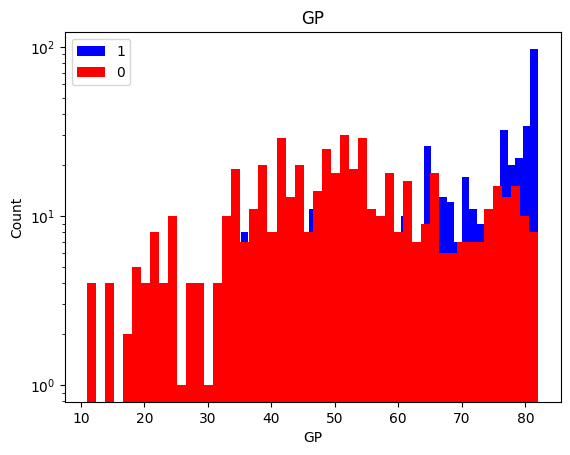

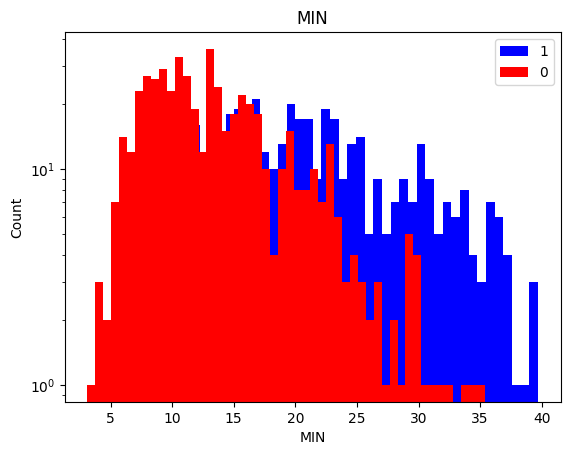

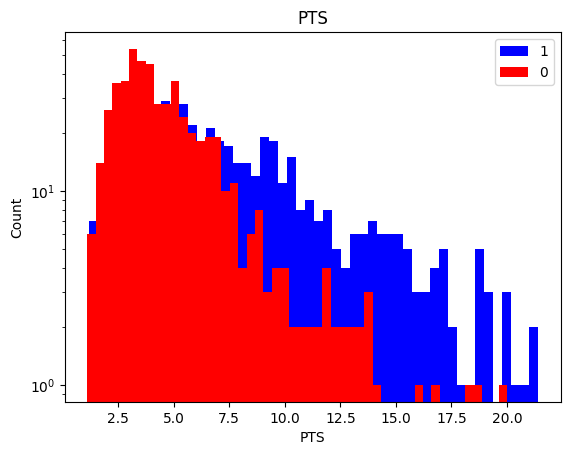

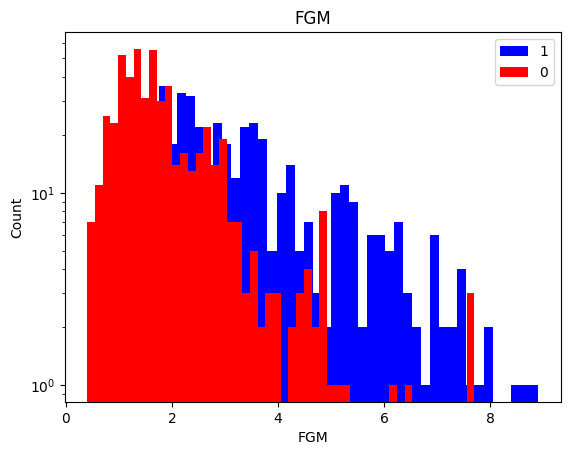

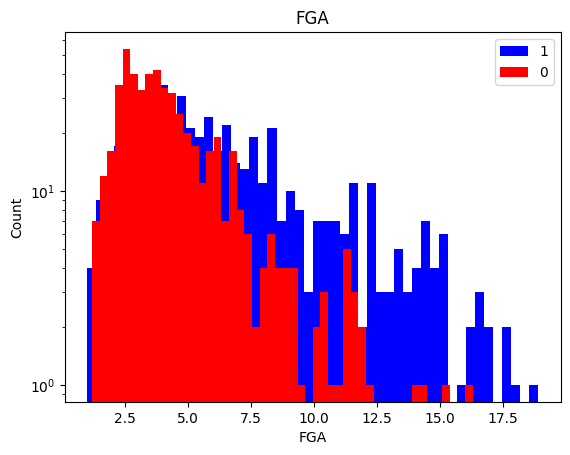

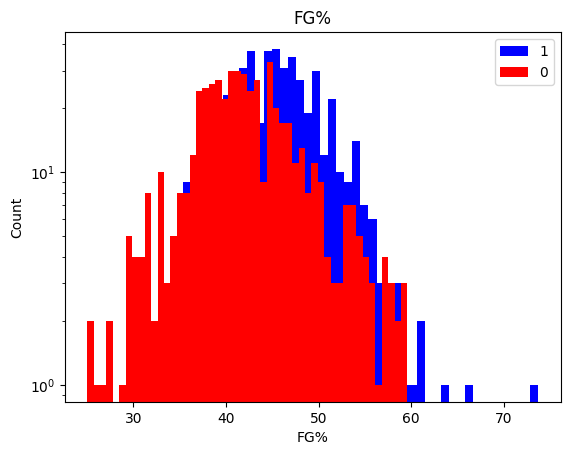

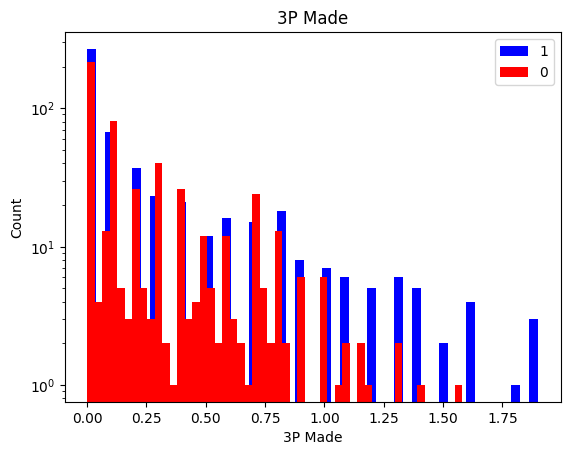

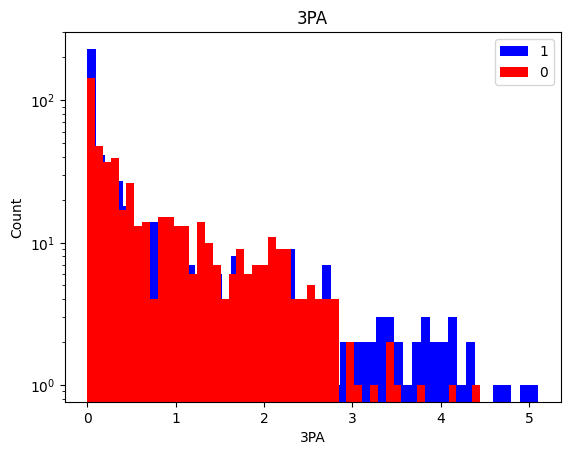

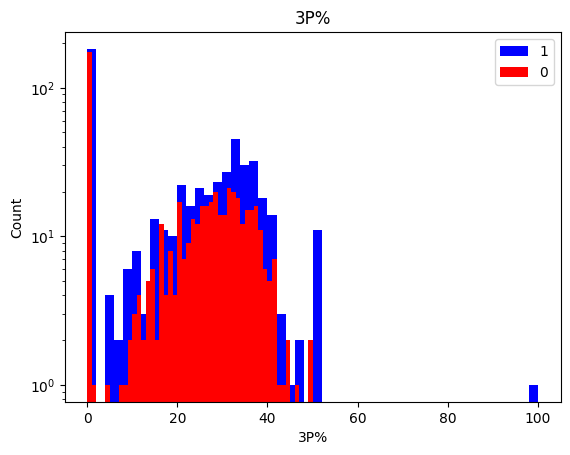

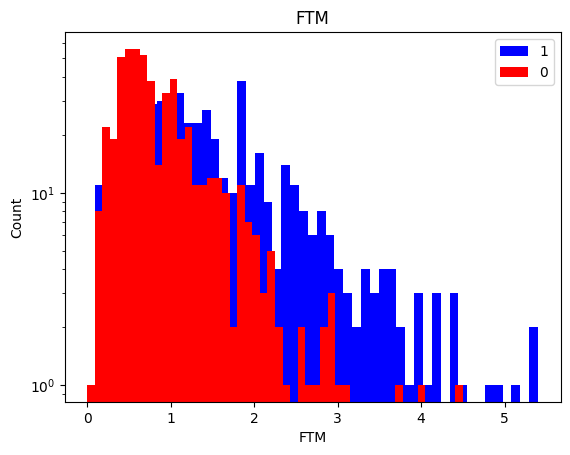

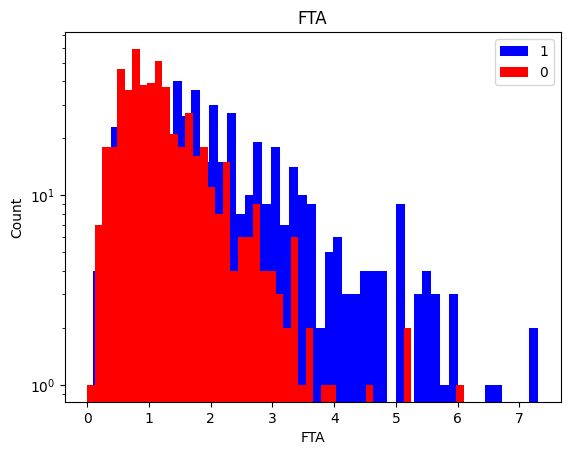

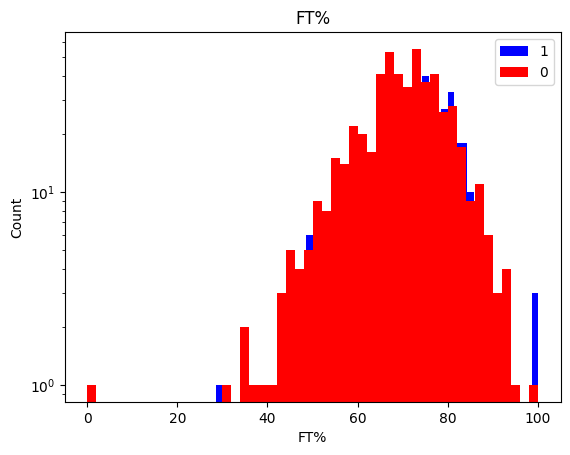

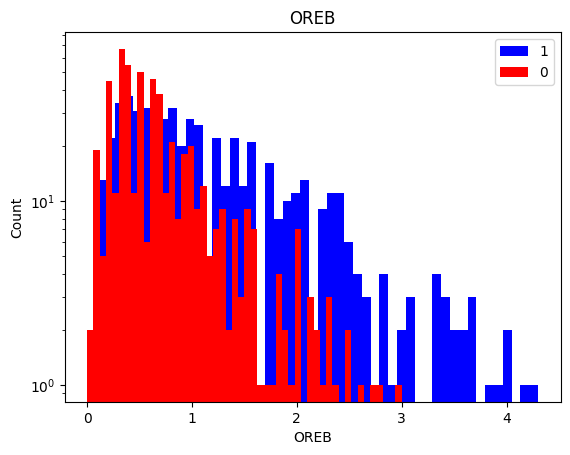

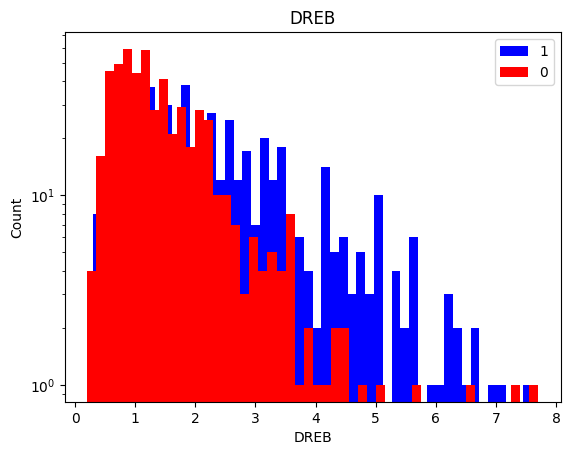

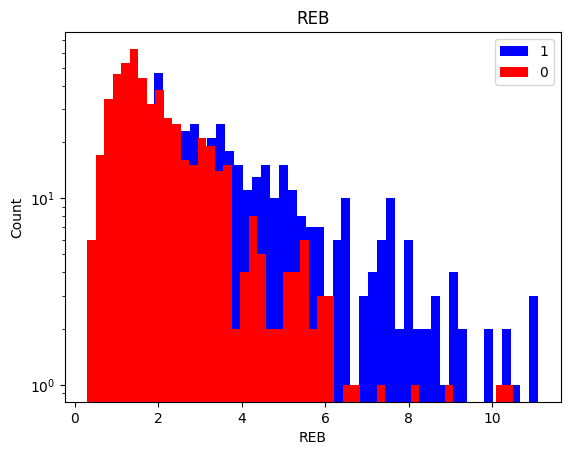

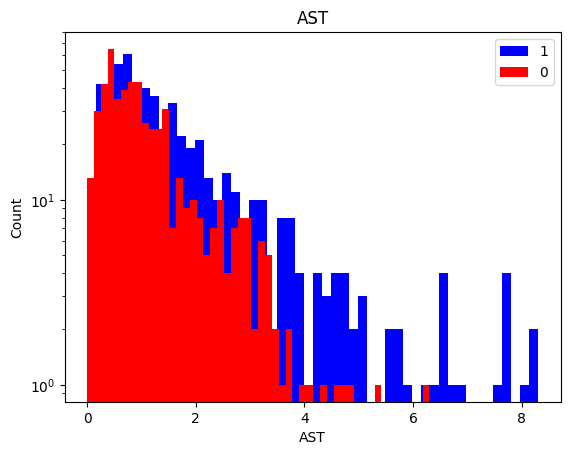

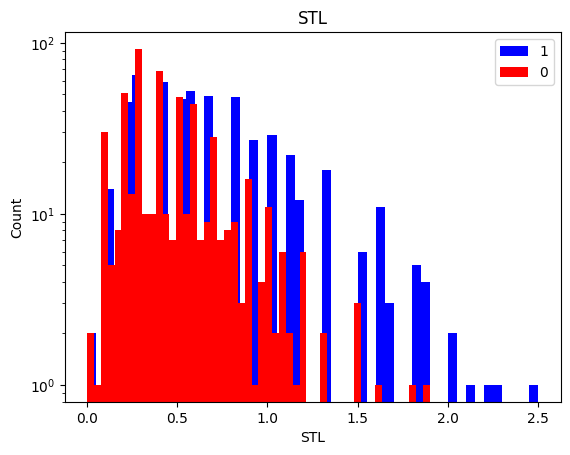

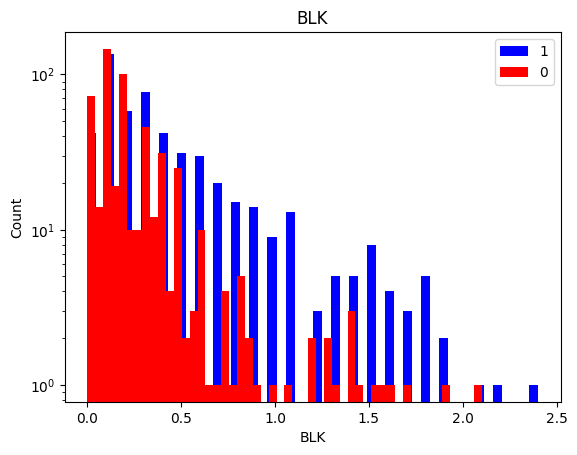

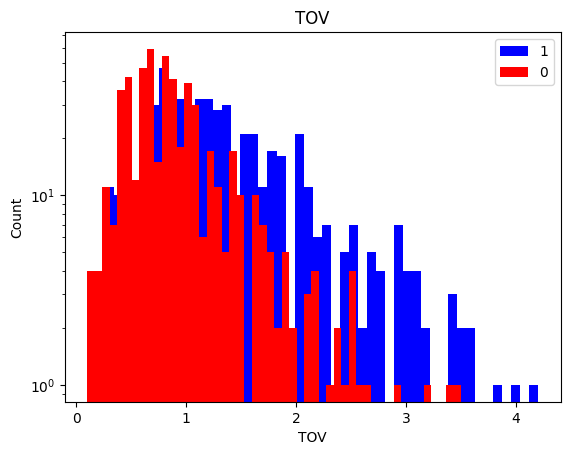

In [12]:
for i, column_name in enumerate(attributes.columns):
    fig: plt.figure = plt.figure(i)
    for binary, color in zip([1, 0], ['b', 'r']):
        plt.hist(attributes.loc[labels_train==binary, column_name], bins = 50, color = color, label = binary)
    plt.legend()
    plt.title(column_name)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.yscale("log")
    plt.show()

The variables linked to percentages of field goal, 3 points attempts and free throws seems to have the same repartition for each class. Those attributes are not deterministic for classification.

We could have think that the number of turnovers is correlated with players having a shorter career, as they are less performing thant the others, but we see here that it is not the case. Therefore, players having a longer career, even if they are better so they tend to make less turnovers, are making turnovers anyway as they are playing more matches than the others, so it is not as discriminating as we first thought.

## Analysis of correlations between attributes

Here we propose an analysis of the correlation matrix.

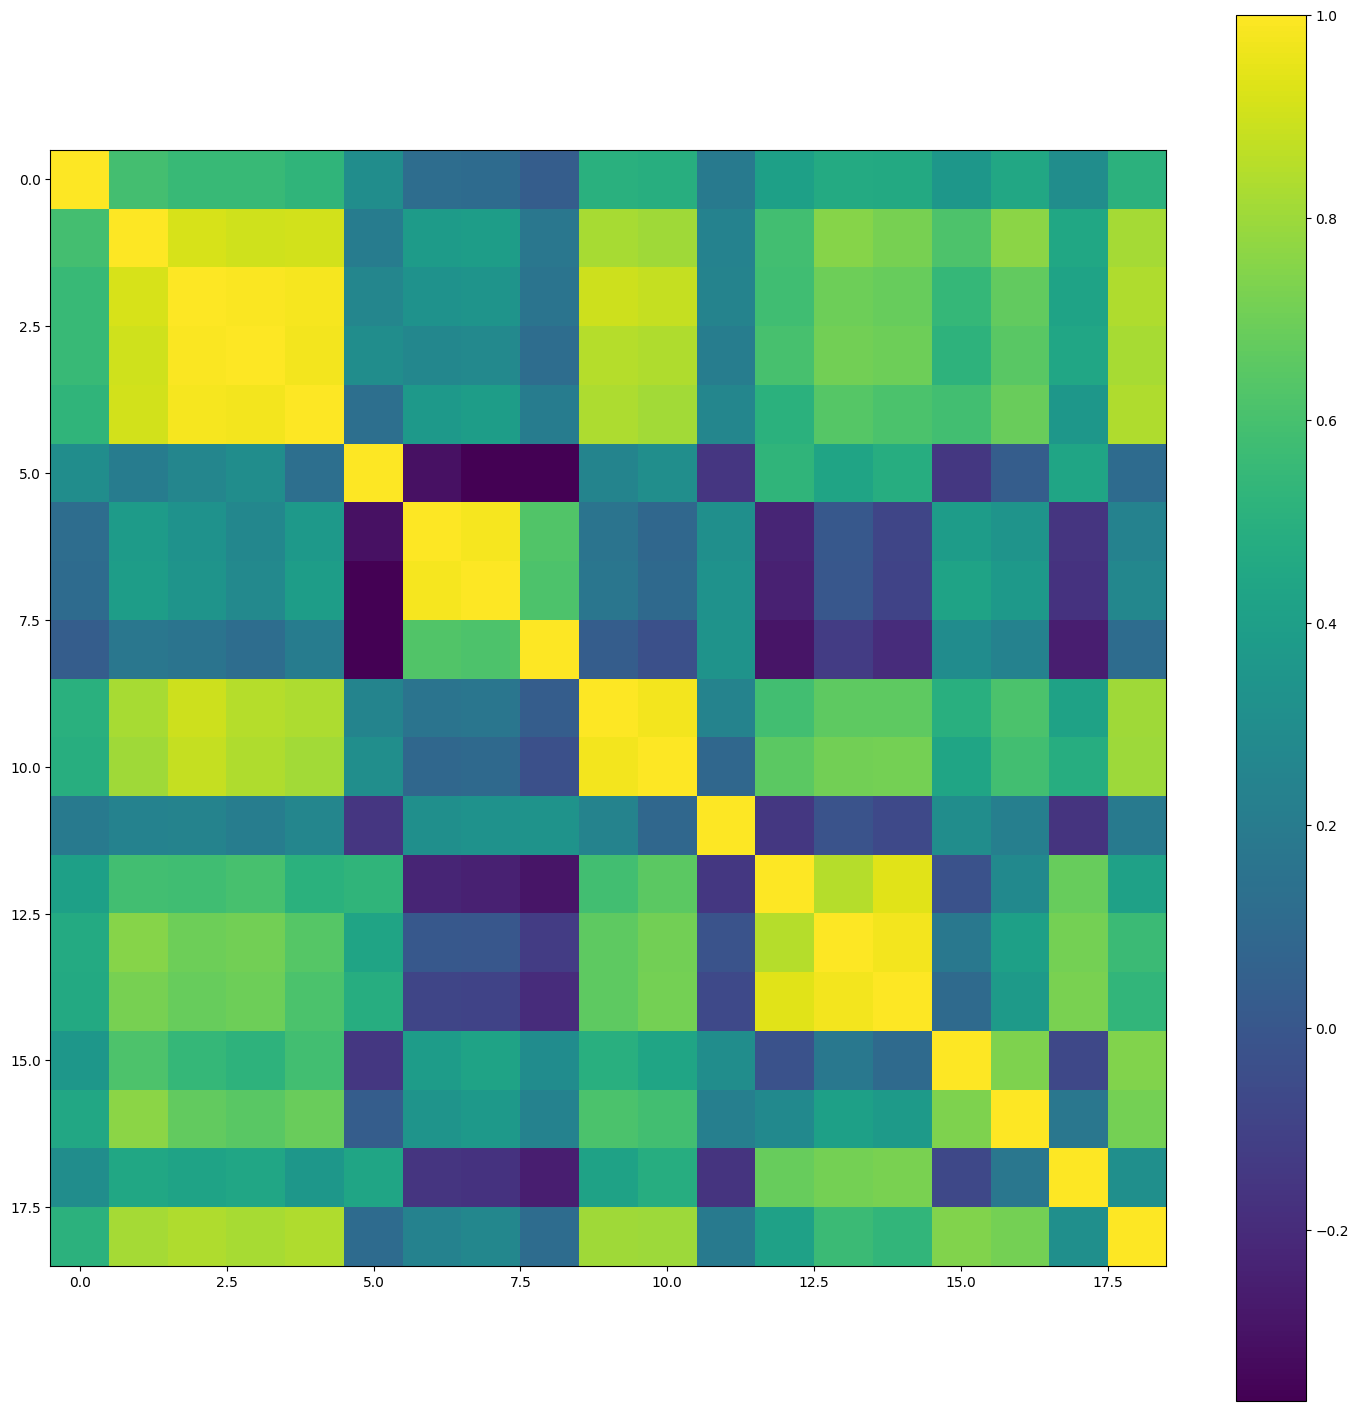

In [13]:
attributes_corr: pd.DataFrame = attributes.corr()
fig: plt.figure = plt.figure(0, figsize = (18,18))
plt.imshow(attributes_corr)
plt.colorbar()

We focus on correlation near -1 or 1 and we fix a treshold at |0.8|

In [14]:
attributes_corr_threshold: pd.DataFrame = attributes_corr.abs() > 0.8
dict_attributes_correlated: Dict[str, List[str]] = {column_name: [idx for idx, value in attributes_corr_threshold[column_name].items() if value and idx != column_name] for column_name in attributes_corr_threshold.columns}

In [15]:
dict_attributes_correlated

{'GP': [],
 'MIN': ['PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'TOV'],
 'PTS': ['MIN', 'FGM', 'FGA', 'FTM', 'FTA', 'TOV'],
 'FGM': ['MIN', 'PTS', 'FGA', 'FTM', 'FTA', 'TOV'],
 'FGA': ['MIN', 'PTS', 'FGM', 'FTM', 'FTA', 'TOV'],
 'FG%': [],
 '3P Made': ['3PA'],
 '3PA': ['3P Made'],
 '3P%': [],
 'FTM': ['MIN', 'PTS', 'FGM', 'FGA', 'FTA', 'TOV'],
 'FTA': ['MIN', 'PTS', 'FGM', 'FGA', 'FTM'],
 'FT%': [],
 'OREB': ['DREB', 'REB'],
 'DREB': ['OREB', 'REB'],
 'REB': ['OREB', 'DREB'],
 'AST': [],
 'STL': [],
 'BLK': [],
 'TOV': ['MIN', 'PTS', 'FGM', 'FGA', 'FTM']}

We see that there are 3 subgroups of highly correlated attributes. For example, the columns _3PA_ et _3P Made_ are highly correlated as most players succeed in the 3 points shoot they attempt. The 3 attributes linked to rebounds are highly correlated as well so we want to keep one only.

We want to identify, for each groups of attributes, the one we want to keep. To perform this, we focus on the importance of each attribute during learning. We perform a learning on a _RandomForestClassifier_ using the module *feature_importances*, which are disponible in the library *scikit_learn*

In [16]:
forest: RandomForestClassifier = RandomForestClassifier()
forest.fit(attributes, labels_train)
importances: np.array(float) = forest.feature_importances_

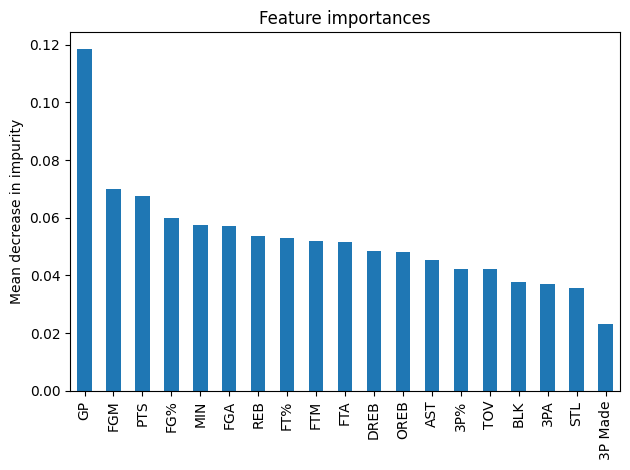

In [17]:
fig: plt.figure
ax: plt.Axes

forest_importances: pd.Series = pd.Series(importances, index=attributes.columns).sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We keep the attribute which is the most important for each group of correlated attributes.

In [18]:
to_drop: List[str] = []
for column_name, list_correlations in dict_attributes_correlated.items():
    if list_correlations and \
        column_name not in to_drop and \
        all(forest_importances[column_name] > forest_importances[list_correlations]):
        to_drop+=list_correlations
attributes_dropped: pd.DataFrame = attributes.drop(columns=to_drop)

Finally, we normalize the learning variables thanks to _MinMaxScaler_ module from library *scikit_learn*

In [19]:
# Re-normalizing the dataset after deletion of extra attributes
normalizer: MinMaxScaler = MinMaxScaler()
normalizer.fit(attributes_dropped)
column_names: List[str] = attributes_dropped.columns
X_train: np.array = normalizer.transform(attributes_dropped)

# Delete extra attributes also for test set
X_test = X_test[column_names].to_numpy().tolist()

# Training

We consider to maximize the following score_classifier

In [20]:
def score_classifier(dataset: np.array, classifier: Any, labels: pd.DataFrame):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    return:
    :f1: F1 Score metric used for learning
    :confusion_matrix: confusion matrix
    :
    """

    kf: KFold = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat: np.array = np.zeros((2,2))
    f1: float = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set: pd.DataFrame = dataset[training_ids]
        training_labels: pd.DataFrame = labels[training_ids]
        test_set: pd.DataFrame = dataset[test_ids]
        test_labels: pd.DataFrame = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels: pd.DataFrame = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        f1 += f1_score(test_labels, predicted_labels)
    f1/=3
    return f1, confusion_mat

In [21]:
f1: float
f1_scores: Dict[str, float] = {}
confusion_mat: np.array
confusion_mats: Dict[str, np.array] = {}
labels: np.array = labels_train.to_numpy()

# Models

We propose to look at three different models. The algorithm of Random Forest, the logistic regression and the support vector classification.

## Grid search

In [22]:
# Grid Search for SVC
svc_reguls: List[float] = [0.01, 0.1, 1.0, 10]
svc_kernels: List[str] = ["linear", "poly", "rbf", "sigmoid"]
grid_search_svc: Dict[Tuple[str, float, str], float] = {}
for regul, kernel in itertools.product(svc_reguls, svc_kernels):
    current_model: SVC = SVC(C=regul, kernel=kernel)
    str_model: str = str(current_model)
    f1, _ = score_classifier(dataset=X_train, classifier=current_model, labels=labels)
    grid_search_svc[(str_model, regul, kernel)] = f1
grid_search_svc = sorted(grid_search_svc.items(), key=lambda x: x[1], reverse=True)
print(f"SVC grid search : {str(grid_search_svc[0][0])} best result with score {str(grid_search_svc[0][1])}")

# Grid Search for Logistic Regression
logreg_reguls: List[float] = [0.01, 0.1, 1.0, 10]
logreg_stopping_criterias: List[float] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
grid_search_logreg: Dict[Tuple[str, float, float], float] = {}
for regul, tol in itertools.product(logreg_reguls, logreg_stopping_criterias):
    current_model: LogisticRegression = LogisticRegression(tol=tol, C=regul)
    str_model: str = str(current_model)
    f1, _ = score_classifier(dataset=X_train, classifier=current_model, labels=labels)
    grid_search_logreg[(str_model, tol, regul)] = f1
grid_search_logreg = sorted(grid_search_logreg.items(), key=lambda x: x[1], reverse=True)
print(f"Logistic Regression grid search : {str(grid_search_logreg[0][0])} best result with score {str(grid_search_logreg[0][1])}")

# Grid Search for Random Forest classification
rf_estimators_nb: List[float] = [10, 50, 100, 500, 1000]
rf_criterion: List[str] = ["gini", "entropy", "log_loss"]
grid_search_rf: Dict[Tuple[str, float, str], float] = {}
for estimator_nb, criterion in itertools.product(rf_estimators_nb, rf_criterion):
    current_model: RandomForestClassifier = RandomForestClassifier(n_estimators=estimator_nb, criterion=criterion)
    str_model: str = str(current_model)
    f1, _ = score_classifier(dataset=X_train, classifier=current_model, labels=labels)
    grid_search_rf[(str_model, estimator_nb, criterion)] = f1
grid_search_rf = sorted(grid_search_rf.items(), key=lambda x: x[1], reverse=True)
print(f"Random Forest grid search : {str(grid_search_rf[0][0])} best result with score {str(grid_search_rf[0][1])}")

SVC grid search : ("SVC(C=10, kernel='linear')", 10, 'linear') best result with score 0.6824315912509279
Logistic Regression grid search : ('LogisticRegression(C=0.1, tol=0.1)', 0.1, 0.1) best result with score 0.6848927412675135
Random Forest grid search : ('RandomForestClassifier(n_estimators=500)', 500, 'gini') best result with score 0.7390019653680105


The results are approximatively the same for logistic regression and support vector classification. The Random Forest classification is more computationally expensive but is also giving the best result. The introduction of randomness in the algorithm is responsible for the performance on large and noisy datasets. In our case, the dataset is not so large but data might be noisy so logistic regression and support vector classification are not performing well at classifying.

# Integration with REST API

We make the integration on a webservice thanks to Flask API. We perform binarisation of the models and transformation of data thanks to the module _pickle_.

## Models

In [23]:
imputer.fit(X_train)

regul_SVC: float = grid_search_svc[0][0][1]
kernel_SVC: str = grid_search_svc[0][0][2]
model_svc: SVC = SVC(C=regul_SVC, kernel=kernel_SVC)
model_svc.fit(X_train,labels_train)

regul_lgrg: float = grid_search_logreg[0][0][1]
tol_lgrg: float = grid_search_logreg[0][0][2]
model_lgrg: LogisticRegression = LogisticRegression(tol=tol_lgrg, C=regul_lgrg)
model_lgrg.fit(X_train,labels_train)

estim_nb_rf: float = grid_search_rf[0][0][1]
criterion_rf: str = grid_search_rf[0][0][2]
model_rf: RandomForestClassifier = RandomForestClassifier(n_estimators=estim_nb_rf, criterion=criterion_rf)
model_rf.fit(X_train,labels_train);

In [24]:
pickle.dump(model_svc, open(c.MODEL_SVC, "wb"))
pickle.dump(model_lgrg, open(c.MODEL_LGRG, "wb"))
pickle.dump(model_rf, open(c.MODEL_RF, "wb"))

pickle.dump(imputer, open(c.IMPUTER, "wb"))
pickle.dump(normalizer, open(c.NORMALIZER, "wb"))

### Lancement de l'API

On introduit le jeu de données d'apprentissage grâce à la variable *input_data*, sous forme de liste, qui va se charger d'effectuer la requête à l'API. Afin de lancer l'API, il faut exécuter le fichier _API.py_ dans un terminal puis la cellule ci-dessous. 

In [25]:
url: str = 'http://0.0.0.0:5000/api/'
input_data: List[float] = X_test
json_input: json = json.dumps(input_data)
headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
r = requests.post(url=url, data=json_input, headers=headers)
printable: str = json.loads(r.text)
print(printable)

[0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1
 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0
 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0
 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0
 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1
 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1
 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1
 0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0
 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1
 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0
 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0
 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1
 0 0 1 1 1 1 0 0 1 0 1 0 

In [26]:
predictions: List[float] = [float(char) for char in printable if char.isnumeric()]
result: pd.DataFrame = pd.DataFrame(input_data, columns = column_names)
result[c.TARGET] = predictions

In [27]:
result

,GP,FGM,FG%,3PA,3P%,FT%,REB,AST,STL,BLK,Target
0,44.0,2.5,45.3,1.3,32.7,65.3,1.4,1.1,0.7,0.2,0.0
1,51.0,1.0,39.0,0.3,23.5,69.8,1.0,0.9,0.6,0.1,0.0
2,51.0,2.2,41.2,0.8,32.5,69.1,1.7,2.1,0.7,0.0,0.0
3,15.0,0.7,27.0,0.0,0.0,66.7,1.5,0.5,0.1,0.1,0.0
4,36.0,2.3,43.1,0.1,50.0,82.0,2.4,0.9,0.3,0.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
550,39.0,3.2,44.6,0.1,0.0,83.2,3.2,1.3,0.6,0.1,0.0
551,62.0,1.4,42.9,0.1,33.3,70.1,1.4,1.7,0.6,0.1,0.0
552,46.0,3.9,58.6,0.0,0.0,66.5,7.7,0.8,0.7,1.0,1.0
553,53.0,1.1,50.0,0.2,33.3,35.0,1.0,0.2,0.3,0.0,0.0
